<a href="https://colab.research.google.com/github/RMoulla/Machine-learning/blob/main/TP_Node_Embeddings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TP : Réseaux de neurones graphiques.

Dans ce TP, on va appliquer les concepts d'extraction de caractéristiques et de node embedding vus en cours sur un dataset classique [Karate Club Network](https://en.wikipedia.org/wiki/Zachary%27s_karate_club).



# Représentation graphique avec networkx


In [1]:
import networkx as nx

## Zachary's karate club network

Zachary's karate club est un graphe décrivant un réseau social de 34 membres d'un club de karaté. Les liens représentent les interactions entre les membres en dehors du club.

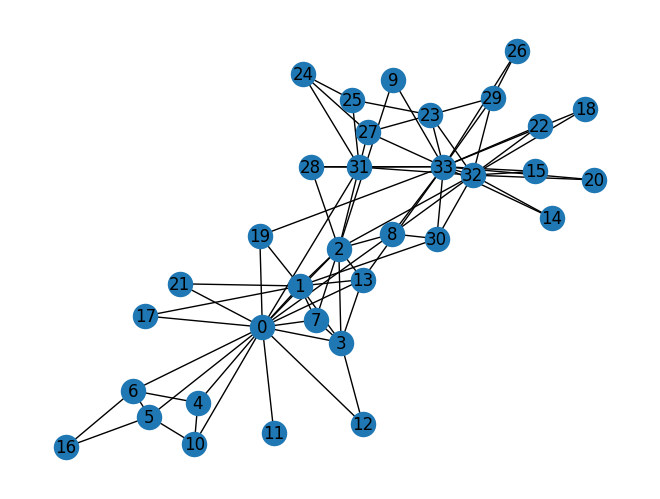

In [2]:
G = nx.karate_club_graph()

nx.draw(G, with_labels = True)

### Networkx : bib discovery :

In [3]:
print(f'Is the graph oriented ? {G.is_directed()}')

Is the graph oriented ? False


In [4]:
print(f'le nombre des noeuds est {G.number_of_nodes()}')
print(f'le nombre des arrêts est {G.number_of_edges()}')
#nx.clustering(G)


le nombre des noeuds est 34
le nombre des arrêts est 78


In [5]:
sp = dict(nx.all_pairs_shortest_path(G))


# Graphe en Tenseur

Nous allons transformer le graphe $G$ en tenseur Pytorch.

In [6]:
import torch

## Liste des arêtes positives du Karaté club en format `torch.LongTensor`.

In [7]:
def graph_to_edge_list(G):

  # Cette fonction retourne la liste des arêtes d'un graphe sous forme
  # de couplet composé de deux noeuds.


  ############# Code ############
  edge_list = []

  for edge in G.edges():
    edge_list.append(edge)
  #########################################
  return edge_list

def edge_list_to_tensor(edge_list):

  # Cette fonction transforme un liste d'arêtes en Tenseur Pytorch
  # de dimension [2 x len(edge_list)]

  edge_index = torch.tensor([])

  ############# Code ############
  edge_index = torch.tensor(edge_list, dtype=torch.long).t().contiguous()
  #########################################

  return edge_index

pos_edge_list = graph_to_edge_list(G)
#print(pos_edge_list)
pos_edge_index = edge_list_to_tensor(pos_edge_list)
print("La dimension de pos_edge_index est : {}".format(pos_edge_index.shape))
print("La somme des valeurs de os_edge_index : {}".format(torch.sum(pos_edge_index)))

La dimension de pos_edge_index est : torch.Size([2, 78])
La somme des valeurs de os_edge_index : 2535




## Liste des arêtes négatives.

In [8]:
import random

def sample_negative_edges(G, num_neg_samples):

  # Cette fonction retourne la liste des arêtes négatives.

  neg_edge_list = []
  pos_edge_list = graph_to_edge_list(G)
  ############# Code ############
  #pourcourir les noeuds
  for i in range(0,(G.number_of_nodes())//2):
    for j in range((G.number_of_nodes())//2,G.number_of_nodes()):
      if (i,j) not in pos_edge_list :
        if (j,i) not in pos_edge_list:
          neg_edge_list.append((i,j))
  neg_edge_list = random.sample(neg_edge_list, num_neg_samples)
  ###############################
  return neg_edge_list

# Echantillon de 78 arêtes négatives
neg_edge_list = sample_negative_edges(G, len(pos_edge_list))

# Convertir la liste des arêtes négatives en tenseur
neg_edge_index = edge_list_to_tensor(neg_edge_list)
print("Le tenseur neg_edge_index est de dimension {}".format(neg_edge_index.shape))


# Echantillon de 78 arêtes négatives
neg_edge_list = sample_negative_edges(G, len(pos_edge_list))

# Convertir la liste des arêtes négatives en tenseur
neg_edge_index = edge_list_to_tensor(neg_edge_list)
print("Le tenseur neg_edge_index est de dimension {}".format(neg_edge_index.shape))


Le tenseur neg_edge_index est de dimension torch.Size([2, 78])
Le tenseur neg_edge_index est de dimension torch.Size([2, 78])


# Node Embeddings

In [9]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA



On va utiliser ici le module [`nn.Embedding`](https://pytorch.org/docs/stable/generated/torch.nn.Embedding.html) de PyTorch.

In [10]:
# Initialisation de la couche d'embeddings
# avec, par exemple, 4 objets de dimension 8 chacun

emb_sample = nn.Embedding(num_embeddings=4, embedding_dim=8)
print('Embedding layer: {}'.format(emb_sample))

Embedding layer: Embedding(4, 8)


In [11]:
id = torch.LongTensor([1])
emb_sample(id)
id


tensor([1])

On peut sélectionner l'embedding d'un objet en utilisant l'indice correspondant.

In [12]:
# Sélectionner un seul embedding
id = torch.LongTensor([1])
print(emb_sample(id))

# Sélectionner plusieurs embeddings
ids = torch.LongTensor([1, 3])
print(emb_sample(ids))

# Obtenir la dimension de la mtrice de poids de l'embedding
shape = emb_sample.weight.data.shape
print(shape)

# Affecter de nouvelles valeurs à la matrice de poids (ici des 1)
emb_sample.weight.data = torch.ones(shape)

# Vérifier la nouvelle affectation
ids = torch.LongTensor([0, 3])
print(emb_sample(ids))

tensor([[ 0.1370,  0.1959, -1.4929,  0.7290,  0.2693,  1.3007,  0.4072, -1.3860]],
       grad_fn=<EmbeddingBackward0>)
tensor([[ 0.1370,  0.1959, -1.4929,  0.7290,  0.2693,  1.3007,  0.4072, -1.3860],
        [ 0.0207, -1.5976,  0.8734, -0.3572, -0.7126, -0.1170,  0.5655,  0.6369]],
       grad_fn=<EmbeddingBackward0>)
torch.Size([4, 8])
tensor([[1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1.]], grad_fn=<EmbeddingBackward0>)


On va appliquer à cela au jeu de données Zachary's karaté club.


*   On veut associer un vecteur de dimension 16 à chaque noeud du graphe.
*   on veut initialiser la matrice avec une distribution uniforme dans $[0, 1]$ en utilisant [`torch.rand`](https://pytorch.org/docs/stable/generated/torch.rand.html).



In [13]:
torch.manual_seed(1)

def create_node_emb(num_node=34, embedding_dim=16):

  # Ecrire une fonction qui implémente la matrice d'embeddings pour les noeuds.
  # La fonction doit retourner un embedding de format torch.nn initalisé selon
  # une loi uniforme dans [0,1].

  emb = None

  ############# Code ############
  emb = nn.Embedding(num_embeddings=num_node, embedding_dim=embedding_dim)
  shape = emb.weight.data.shape
  emb.weight.data = torch.rand(shape)
  ###############################

  return emb

emb = create_node_emb()
ids = torch.LongTensor([0, 3])

print("Embedding: {}".format(emb))

print(emb(ids))

Embedding: Embedding(34, 16)
tensor([[0.2114, 0.7335, 0.1433, 0.9647, 0.2933, 0.7951, 0.5170, 0.2801, 0.8339,
         0.1185, 0.2355, 0.5599, 0.8966, 0.2858, 0.1955, 0.1808],
        [0.7486, 0.6546, 0.3843, 0.9820, 0.6012, 0.3710, 0.4929, 0.9915, 0.8358,
         0.4629, 0.9902, 0.7196, 0.2338, 0.0450, 0.7906, 0.9689]],
       grad_fn=<EmbeddingBackward0>)


## Visualisation des embeddings

Nous allons projet les embeddings inialisés ci-dessous en deux dimensions afin de les visualiser.

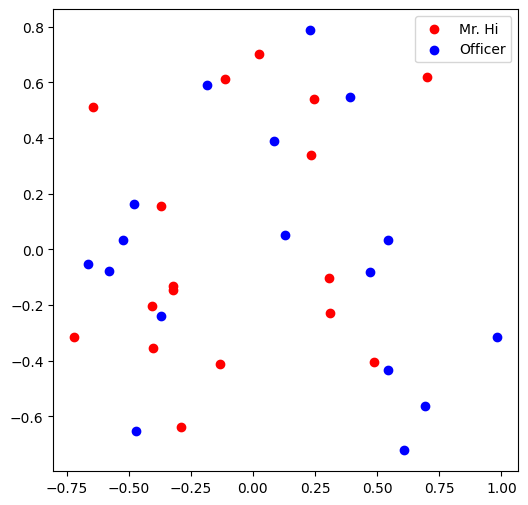

In [14]:
def visualize_emb(emb):#Fonction utilise PCA pour réduire la dimension des embeddings à 2
  X = emb.weight.data.numpy()
  pca = PCA(n_components=2)
  components = pca.fit_transform(X)
  plt.figure(figsize=(6, 6))
  club1_x = []
  club1_y = []
  club2_x = []
  club2_y = []
  for node in G.nodes(data=True):
    if node[1]['club'] == 'Mr. Hi':
      club1_x.append(components[node[0]][0])
      club1_y.append(components[node[0]][1])
    else:
      club2_x.append(components[node[0]][0])
      club2_y.append(components[node[0]][1])
  plt.scatter(club1_x, club1_y, color="red", label="Mr. Hi")
  plt.scatter(club2_x, club2_y, color="blue", label="Officer")
  plt.legend()
  plt.show()

visualize_emb(emb)

## Calcul des embeddings par descente du gradient.

## Visualisation des embeddings calculés

In [15]:
from torch.optim import SGD
from torch.nn import MSELoss
from torch.nn import BCELoss

def accuracy(pred, label):
  # Cette fonction prend les prédictions réalisées,
  # les arrondit et calcul la précision du modèle.

  accu = 0.0
  accu = torch.sum(torch.round(pred) == label) / pred.shape[0]

  return accu

def train(emb, loss_fn, sigmoid, train_label, train_edge):
  # Cette fonction entraîne les embeddings par SGD.
  # A faire :
  # 1 : récupérer les embeddings respectifs des noeuds à partir de train_edge
  # 2 : Calculer le produit scalaire des embeddings de chaque paire de noeuds
  # 3 : Appliquer une fonction sigmoïde au produit scalaire calculé
  # 4 : Appliquer la loss_fn au résultat de la fonction sigmoïde
  # 5 : Imprimer la fonction loss et la précision à chaque epoch.
  # (as a sanity check, the loss should decrease during training)

  epochs = 500
  learning_rate = 0.05

  optimizer = SGD(emb.parameters(), lr=learning_rate, momentum=0.6)

  for i in range(epochs):


    ############# Code ###########
    optimizer.zero_grad()
    # 1. Récupérer les embeddings respectifs des noeuds à partir de train_edge
    src_emb = emb(train_edge[0])
    dst_emb = emb(train_edge[1])

    # 2. Calculer le produit scalaire des embeddings de chaque paire de noeuds
    dot_product = torch.sum(src_emb * dst_emb, dim=1)


    # 3. Appliquer une fonction sigmoïde au produit scalaire calculé
    score = sigmoid(dot_product)

    # 4. Appliquer la loss_fn au résultat de la fonction sigmoïde
    loss = loss_fn(score, train_label)

    # Backpropagation
    loss.backward()
    optimizer.step()
# Affichage de la fonction de perte et de la précision à chaque epoch
    if i % 50 == 0:
      acc = accuracy(score, train_label)
      print(f"Epoch {i+1}/{epochs} - Loss: {loss.item()} - Accuracy: {acc.item()}")


    ##############################


# Générer les labels positifs et négatifs
pos_label = torch.ones(pos_edge_index.shape[1], )
neg_label = torch.zeros(neg_edge_index.shape[1], )

# Concaténer les labels positifs and négatifs dans le même tenseur
train_label = torch.cat([pos_label, neg_label], dim=0)
train_edge = torch.cat([pos_edge_index, neg_edge_index], dim=1)
# Définition de la fonction de perte
loss_fn = BCELoss()
train(emb, loss_fn, torch.sigmoid, train_label, train_edge)

Epoch 1/500 - Loss: 2.0685455799102783 - Accuracy: 0.5
Epoch 51/500 - Loss: 1.423924446105957 - Accuracy: 0.5
Epoch 101/500 - Loss: 1.0493981838226318 - Accuracy: 0.5
Epoch 151/500 - Loss: 0.840991199016571 - Accuracy: 0.5
Epoch 201/500 - Loss: 0.7139925956726074 - Accuracy: 0.557692289352417
Epoch 251/500 - Loss: 0.6260654926300049 - Accuracy: 0.6025640964508057
Epoch 301/500 - Loss: 0.5576181411743164 - Accuracy: 0.6794871687889099
Epoch 351/500 - Loss: 0.4996800124645233 - Accuracy: 0.7435897588729858
Epoch 401/500 - Loss: 0.44834449887275696 - Accuracy: 0.7756410241127014
Epoch 451/500 - Loss: 0.40216338634490967 - Accuracy: 0.8589743375778198


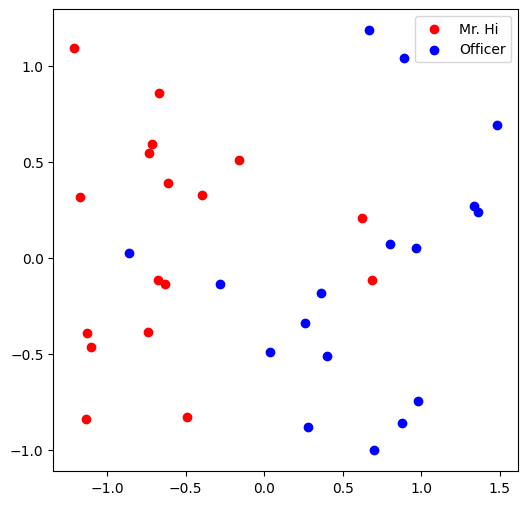

In [16]:
visualize_emb(emb)

 * **Les nœuds forment des clusters selon leur appartenance au club, ce qui indique que les embeddings capturent certaines des structures communautaires du réseau. Cela suggère que des nœuds similaires sont placés plus près les uns des autres dans l'espace des embeddings.**


 * **Il y a une séparation visible entre les deux clubs, mais avec de proximité entre les groupes. Cette proximité peut être si des membres des deux clubs ont des liens entre eux.**

